### Example: Unwrapping a lamellipodia

To illustrate the unwrapping steps, we will use an example of a lamellipodia which was segmented from the surface of a cell. 

The mesh is located in `../../data/mesh/protrusions/lamellipodia_protrusion_01.obj`. We will show:

1. conformal map to disk
2. equiareal disk map by relaxing area distortion
3. obtain a square map by 'squaring' the disk
4. optimize the aspect ratio of the square map using the beltrami coefficient 

#### 0. Read in the surface mesh

In [73]:
import unwrap3D.Mesh.meshtools as meshtools
import unwrap3D.Utility_Functions.file_io as fio # for common IO functions
import unwrap3D.Unzipping.unzip as uzip

import os
import numpy as np
import pylab as plt 

"""
Specifying image file location and parsing its name. 
"""
meshfolder = '../../data/mesh/protrusions'
meshfile = os.path.join(meshfolder, 'lamellipodia_protrusion_01.obj')

basefname = os.path.split(meshfile)[-1].split('.obj')[0] # get the filename with extension

mesh_S = meshtools.read_mesh(meshfile,
                             keep_largest_only=True) # read only the largest if there is multiple separate objects in the mesh

# parse the curvature colormap
curvature_color = mesh_S.visual.vertex_colors[:,:3]

"""
Create a master save folder
"""
savefolder = os.path.join('example_results', 
                         basefname)
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


"""
Visualize the input mesh
"""



'\nVisualize the input mesh\n'

#### 1. conformal map to the unit disk

If the input mesh has poor triangle quality, then it is recommended to perform isotropic remesh. Furthermore, If the input mesh has holes, detected by checking the number of outputs of `igl.all_boundary_loop` after importing the `igl` library. If it is greater than 1, then you will need to first conduct mesh repair to 'fill-in' the holes (all loops that is not the longest) so that the surface is simple. 

detected 1 boundaries
(3057, 2)


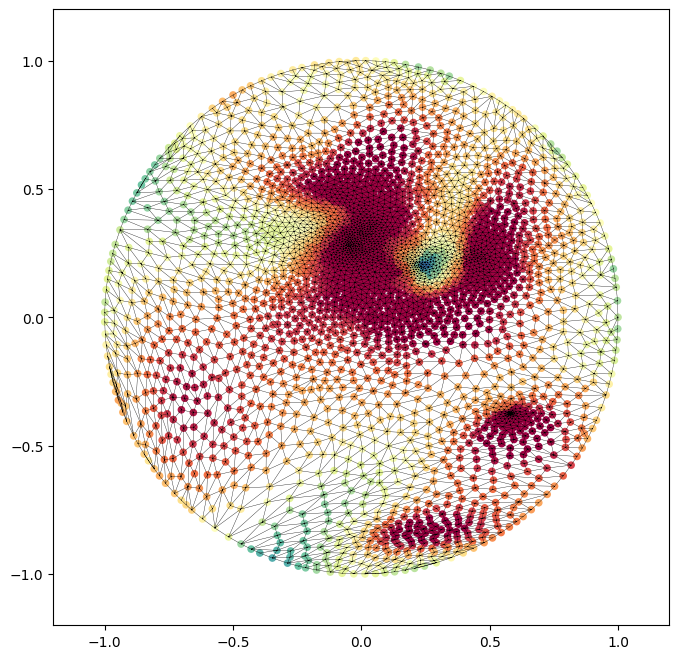

In [74]:
# check for holes
import igl 

boundaries = igl.all_boundary_loop(mesh_S.faces) # we expect only 1
print('detected %d boundaries' %(len(boundaries)))
assert(len(boundaries)==1)

# perform isotropic remeshing (just in case)
# mesh_S = meshtools.incremental_isotropic_remesh(mesh_S)

# the disk mapping is provided via the rectangular conformal mapping function.
disk_coords = meshtools.rectangular_conformal_map(mesh_S.vertices,
                                                  mesh_S.faces,
                                                  corner=None,  
                                                  random_state=0)

print(disk_coords.shape)


# scatter plot the vertices, plot the face connectivity using matplotlib triplot
plt.figure(figsize=(8,8))
plt.scatter(disk_coords[:,0],
            disk_coords[:,1], 
            s=20, 
            c=curvature_color/255.)
plt.triplot(disk_coords[:,0],
            disk_coords[:,1], 
            mesh_S.faces, 
            'k-', lw=.25)
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])
plt.gca().set_aspect('equal')
plt.show()

# create a mesh of the disk
disk_mesh = mesh_S.copy()
disk_mesh.vertices = np.hstack([np.ones(len(disk_coords))[:,None], 
                                disk_coords]) # we need to make it 3D to save in mesh format
tmp = disk_mesh.export(os.path.join(savefolder,
                                    'conformal_disk_'+basefname+'.obj'))

#### 2. equiareal disk map by relaxation

Unlike the spherical case, the topology changes in the area relaxation. This is because the relaxation here is much more sensitive to triangulation. Each iteration uses delaunay triangle flipping to improve triangulation and mitigate foldovers. Consequently in each step we have vertices, `v` and faces, `f`. The number of vertices is the same, the connectivity of `f` changes per iteration.

In [75]:
v_steps, f_steps, area_distortion_iter = meshtools.area_distortion_flow_relax_disk(disk_mesh, 
                                                                                    mesh_S, 
                                                                                    max_iter=50,
                                                                                    delta_h_bound=0.5, 
                                                                                    stepsize=1., 
                                                                                    flip_delaunay=True, 
                                                                                    robust_L=False, # we can relax more by setting this off
                                                                                    mollify_factor=1e-5,
                                                                                    eps = 1e-2, # regularization factor
                                                                                    debugviz=False,
                                                                                    debugviz_tri=False) # set True if you want to watch the mesh relax.



  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:05<00:00,  9.22it/s]


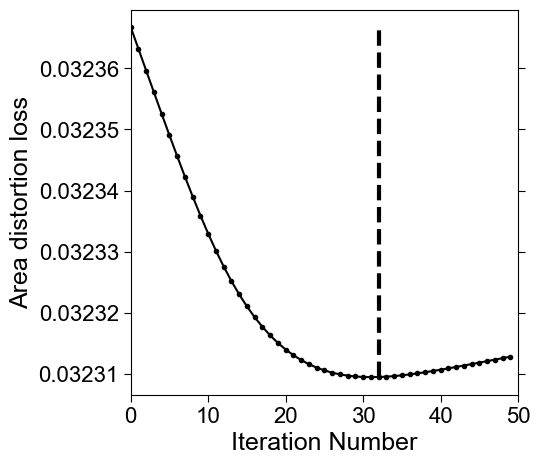

In [76]:
import unwrap3D.Analysis_Functions.timeseries as tsa

# monitor the mean area distortion per iteration to find the optimal stopping
mean_area_distortion_iter = np.nanmean(np.array(area_distortion_iter),axis=1) 

if len(area_distortion_iter) > 0:
    # smooth the area_distortion_curve helps finding the stopping, unlike spherical case, this curve is typically more bumpy 
    mean_area_distortion_iter = tsa.baseline_als(mean_area_distortion_iter, lam=1000, p=0.1) 


    change = np.arange(len(mean_area_distortion_iter))[1:][np.diff(mean_area_distortion_iter)>0] 

    if len(change) > 0: 
        min_distort_id = np.maximum(0, change[0]) 
    else:
        min_distort_id = np.maximum(0,len(mean_area_distortion_iter))
else:
    min_distort_id = 0


# plot the curve and overlay the final 
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(np.arange(0,len(mean_area_distortion_iter)), 
          mean_area_distortion_iter, '.-', color='k')
plt.vlines(min_distort_id, 
            np.nanmin(mean_area_distortion_iter[~np.isinf(mean_area_distortion_iter)]), 
            np.nanmax(mean_area_distortion_iter[~np.isinf(mean_area_distortion_iter)]), 'k', linestyles='dashed', lw=3)
plt.tick_params(length=5, right=True)
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.xlim([0,50])
plt.xlabel('Iteration Number', fontsize=18, fontname='Arial')
plt.ylabel('Area distortion loss', fontsize=18, fontname='Arial')
plt.savefig(os.path.join(savefolder, 
                          'area-distortion_relax_iterations_'+basefname.replace('.obj', '.svg')), bbox_inches='tight')
plt.show()


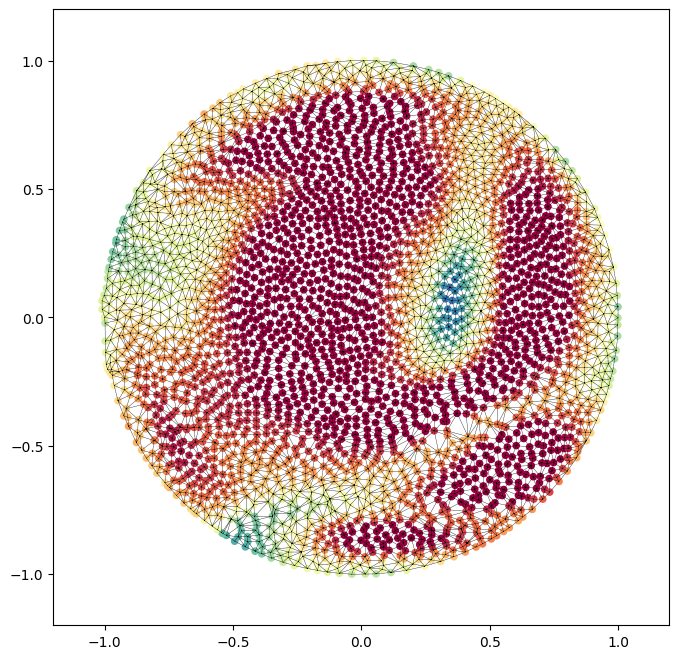

In [77]:
# create the new mehs
equiareal_disk_mesh = disk_mesh.copy()
equiareal_disk_mesh.vertices[:,1:] = v_steps[min_distort_id][:,1:] # this is if we want to maintain the same 1st coordinate as the disk_mesh we created earlier
equiareal_disk_mesh.faces = f_steps[min_distort_id] 

tmp = equiareal_disk_mesh.export(os.path.join(savefolder,
                                    'equiareal_disk_'+basefname+'.obj'))

# revisualize: scatterplot the vertices, plot the face connectivity using matplotlib triplot
disk_coords = equiareal_disk_mesh.vertices[:,1:].copy()

plt.figure(figsize=(8,8))
plt.scatter(disk_coords[:,0],
            disk_coords[:,1], 
            s=20, 
            c=curvature_color/255.)
plt.triplot(disk_coords[:,0],
            disk_coords[:,1], 
            equiareal_disk_mesh.faces, 
            'k-', lw=.25)
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])
plt.gca().set_aspect('equal')
plt.show()

#### 3. squaring the disk

There are a number of bijective mathematical transformations that have been developed to 'square the disk' and the inverse, 'circularize the square'. See Fong's [Analytical Methods for Squaring the Disc](https://arxiv.org/pdf/1509.06344v1) for the mathematical formulae and explanations. These mappings transform the unit disk to the unit square and vice-versa. They do not change the number of vertices or the face connectivity. 

u-Unwrap3D implements the squircircle and elliptical-powell in the geometry module, `unwrap3D.Geometry.geometry`. Here we will use the elliptical-powell method.

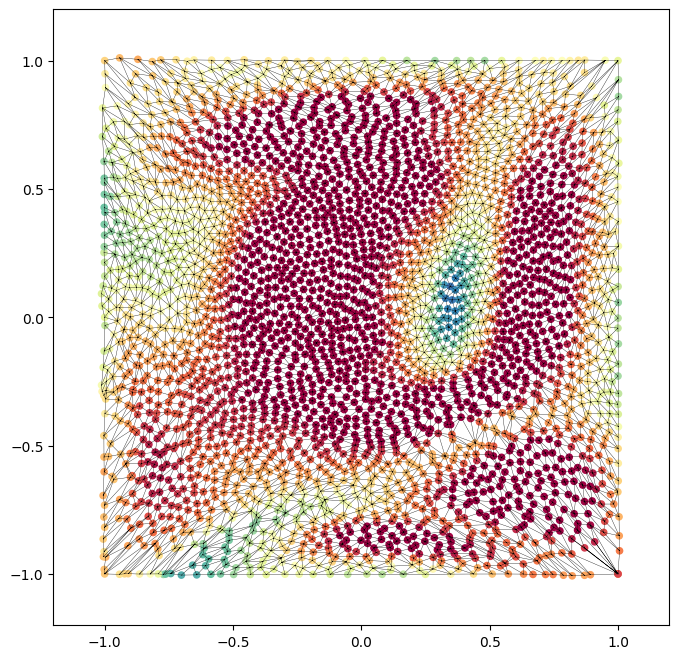

In [78]:
import unwrap3D.Geometry.geometry as geom

square_coords = geom.elliptical_nowell(disk_coords)

square_mesh = equiareal_disk_mesh.copy()
square_mesh.vertices[:,1:] = square_coords

tmp = square_mesh.export(os.path.join(savefolder,
                                    'equiareal_square_'+basefname+'.obj'))

# revisualize: scatterplot the vertices, plot the face connectivity using matplotlib triplot

plt.figure(figsize=(8,8))
plt.scatter(square_coords[:,0],
            square_coords[:,1], 
            s=20, 
            c=curvature_color/255.)
plt.triplot(square_coords[:,0],
            square_coords[:,1], 
            square_mesh.faces, 
            'k-', lw=.25)
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])
plt.gca().set_aspect('equal')
plt.show()

#### 4. optimizing the aspect ratio of the square

Just as we can optimize the aspect ratio of uv map for spherical parameterization. We can also use criteria such as the Beltrami coefficient to optimize the aspect ratio of the square parmeterization of the open surface.


NaN result encountered.
optimal length of y-axis as fraction of x-axis:  1.9098300562505255


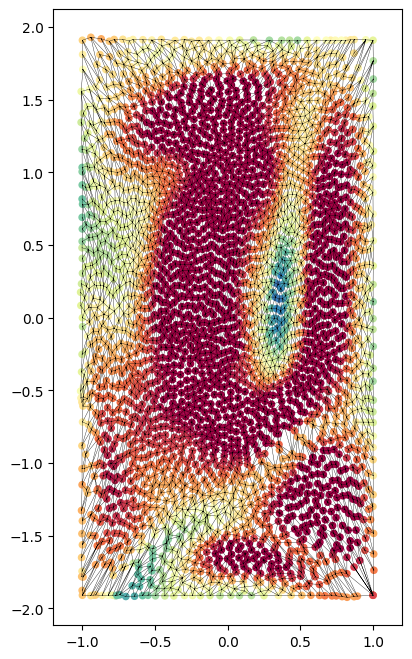

In [79]:
from scipy.optimize import fminbound
from unwrap3D.Mesh.meshtools import beltrami_coefficient

square = square_coords.copy()
f = mesh_S.faces
v = mesh_S.vertices

def func(h):
    return np.sum(np.abs(beltrami_coefficient(np.hstack([square[:,0][:,None],h*square[:,1][:,None]]), f, v))**2)

h_opt = fminbound(func, 0, 5);
print('optimal length of y-axis as fraction of x-axis: ', h_opt)
square_opt = np.vstack([square[:,0], h_opt*square[:,1]]).T;


square_mesh_opt = square_mesh.copy()
square_mesh_opt.vertices[:,1:] = square_opt

tmp = square_mesh_opt.export(os.path.join(savefolder,
                                    'equiareal_rectangle_'+basefname+'.obj'))

# revisualize: scatterplot the vertices, plot the face connectivity using matplotlib triplot

plt.figure(figsize=(8,8))
plt.scatter(square_opt[:,0],
            square_opt[:,1], 
            s=20, 
            c=curvature_color/255.)
plt.triplot(square_opt[:,0],
            square_opt[:,1], 
            square_mesh_opt.faces, 
            'k-', lw=.25)
plt.xlim([-1.2,1.2])
plt.gca().set_aspect('equal')
plt.show()
